In [1]:
# https://medium.com/towards-data-science/transfer-learning-using-keras-d804b2e04ef8

In [1]:
import os
import pandas as pd
import numpy as np
import glob 
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
from PIL import Image
from IPython import display 

import sklearn.preprocessing

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.models import load_model
from keras.utils import to_categorical
from keras.metrics import top_k_categorical_accuracy

Using TensorFlow backend.


In [2]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
def top3(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top5(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

# Exploration

## Exploration du dataset

In [2]:
label = pd.read_csv("labels.csv")

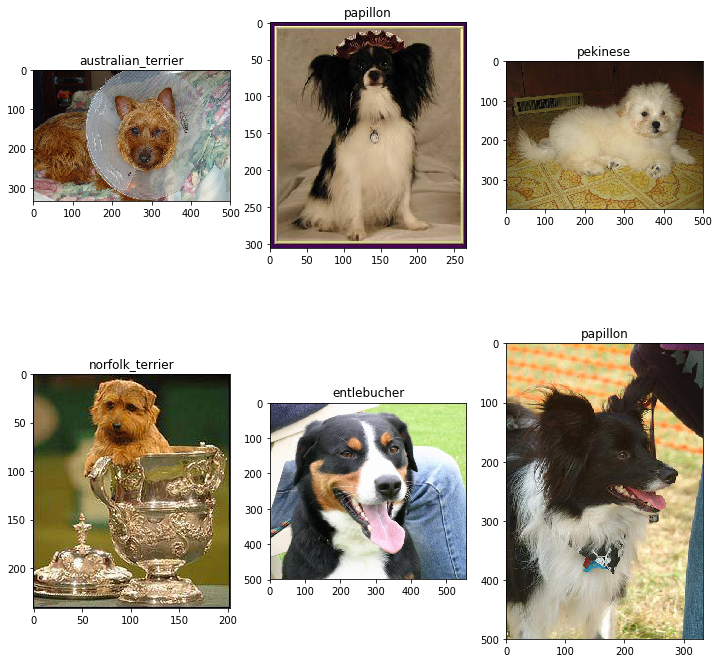

In [55]:
elems = label.ix[random.sample(range(len(label)), 6)][['id', "breed"]].values

f, axarr = plt.subplots(2, 3, figsize=(12,12))
for i in range(6):
    url = os.path.join("train/", elems[i][0] + ".jpg")
    pil_im = Image.open(url)
    name = elems[i][1]
    line = i//3
    column = i%3
    axarr[line, column].imshow(np.asarray(pil_im))
    axarr[line, column].set_title(name)
plt.show()

In [138]:
label.groupby("breed").agg({"id" : "count"})["id"].describe()

count    120.000000
mean      85.183333
std       13.298122
min       66.000000
25%       75.000000
50%       82.000000
75%       91.250000
max      126.000000
Name: id, dtype: float64

On a entre 66 et 126 images pour chaque classes. C'est donc un dataset a peu près balanced

## Paramètres des images

### Récupération des données

In [84]:
# img = []
# height_list = []
# width_list = []

# for filename in glob.glob('test/*.jpg'):
#     im = Image.open(filename)
#     w, h = im.size
#     img.append(filename)
#     height_list.append(h)
#     width_list.append(w)

# for filename in glob.glob('train/*.jpg'):
#     im = Image.open(filename)
#     w, h = im.size
#     img.append(filename)
#     height_list.append(h)
#     width_list.append(w)
    
# for filename in glob.glob('train/*.jpg'):
#     im = Image.open(filename)
#     w, h = im.size
#     img.append(filename)
#     height_list.append(h)
#     width_list.append(w)

# df = pd.DataFrame({"Image" : img, "Height" : height_list, "Width" : width_list})

# df.to_csv("img_format.csv")

In [86]:
df= pd.read_csv("img_format.csv", index_col=0)

### Taille des images

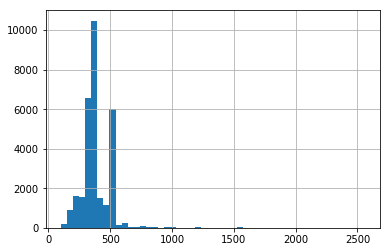

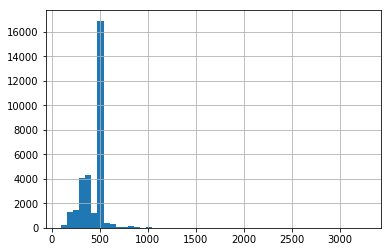

In [127]:
df["Height"].hist(bins=50)
plt.show()

df["Width"].hist(bins=50)
plt.show()

### Nombre de Pixels

In [128]:
df["Pixels"] = df["Height"]*df["Width"]

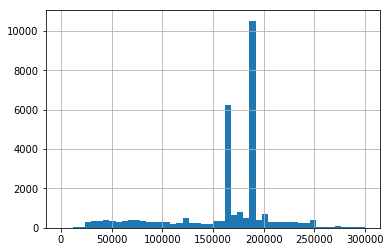

In [129]:
df["Pixels"].hist(bins=50, range = (0, 300000))
plt.show()

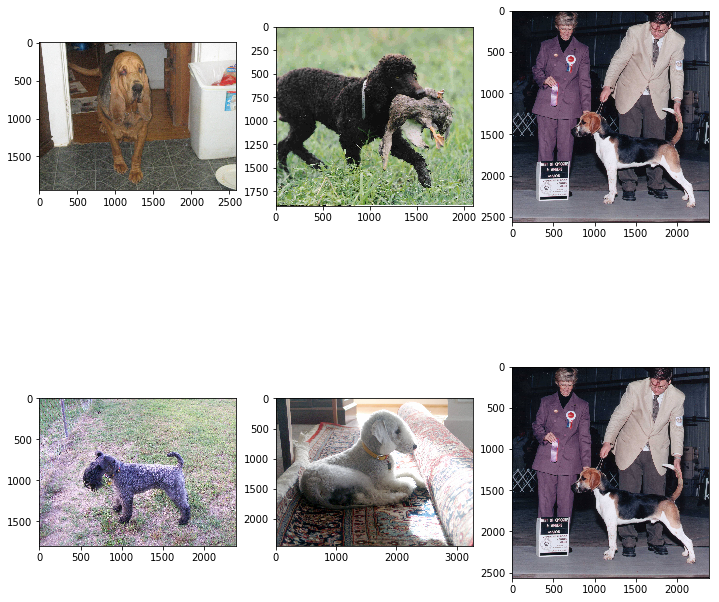

In [119]:
sublabel = df[df["Pixels"] > 4e6]
elems = sublabel.iloc[random.sample(range(len(sublabel)), 6)]["Image"].values
elems[1]

f, axarr = plt.subplots(2, 3, figsize=(12,12))
for i in range(6):
    url = os.path.join(elems[i])
    pil_im = Image.open(url)
    line = i//3
    column = i%3
    axarr[line, column].imshow(np.asarray(pil_im))
plt.show()

### Ratio W/H

Comme on va scaler les images avant d'entrainer le reseau, il faudrait regarder les images avec un fort Ratio W/H

In [121]:
df["Ratio"] = df["Height"]/df["Width"]

In [126]:
len(df[(df["Ratio"] > 2) | (df["Ratio"] < 0.5)])

67

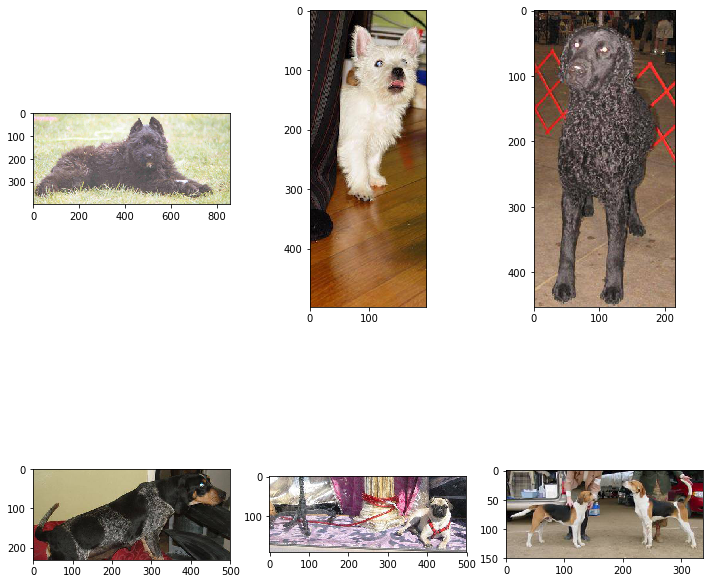

In [125]:
sublabel = df[(df["Ratio"] > 2) | (df["Ratio"] < 0.5)]
elems = sublabel.iloc[random.sample(range(len(sublabel)), 6)]["Image"].values
elems[1]

f, axarr = plt.subplots(2, 3, figsize=(12,12))
for i in range(6):
    url = os.path.join(elems[i])
    pil_im = Image.open(url)
    line = i//3
    column = i%3
    axarr[line, column].imshow(np.asarray(pil_im))
plt.show()

### Image à retravailler

Avant de passer au modèle, on va retoucher quelques images à la main. Etant donnée que l'on a pas de Région Boundaries fourni avec le dataset, il est difficile de réduire automatiquement l'image à un ratio voulu

Les images ayant beaucoup de pixels étant plutot avec un faible ratio W/H, on ne va retravailler que les images de training ayant un fort/faible ratio W/H. L'objectif étant d'éviter que le modèle n'apprenent des features inutiles ou que le rescale en preprocessing écrase trop les features

In [159]:
len(df[((df["Ratio"] > 1.8) | (df["Ratio"] < 0.5)) & (df["Image"].str.contains("train")) ]["Image"])

74

In [160]:
rework = df[((df["Ratio"] > 1.8) | (df["Ratio"] < 0.5)) & (df["Image"].str.contains("train")) ]["Image"]

In [161]:
for image in rework.values:
    try:
        name = os.path.basename(image)
        os.rename(os.path.join("train", name), os.path.join("train", "rework", name))
    except:
        pass

Les images dans le dossier rework ont donc été coupé a la main pour garder une zone a peu près carré logique et car il y en avait pas beaucoup (env 30). Dans d'autres situations, il faudrait peut-etre mettre en place un algo qui reduit la région ou est le chien (region proposal network)

# Preparation

## Inputs

Les tailles d'inputs sont réglementés pour les pre-trained NN comme suit :

<ul>
<li>(299, 299, 3) : Xception</li>
<li>(224, 224, 3) : VGG16 / VGG19</li>
<li>(224, 224, 3) : ResNet50</li>
<li>(299, 299, 3) : InceptionV3</li>
<li>(299, 299, 3) : InceptionResNetV2</li>
<li>(224, 224, 3) : MobileNet</li>
</ul>

In [25]:
# for filename in glob.glob('test/*.jpg'):
#     img = Image.open(filename)
#     img = img.resize((299, 299), Image.ANTIALIAS)
#     img.save(os.path.join("test/resized/", os.path.basename(filename)))
    
# for filename in glob.glob('train/*.jpg'):
#     img = Image.open(filename)
#     img = img.resize((299, 299), Image.ANTIALIAS)
#     img.save(os.path.join("train/resized/", os.path.basename(filename)))

# data augmentation

In [60]:
# a = label["id"].tolist()
# b = [x[::-1] for x in a]
# print(set(a) & set(b))

set()


In [72]:
# for filename in glob.glob('train/resized/*.jpg'):
#     name_img = os.path.basename(filename)[:-4]
#     path = os.path.dirname(filename)
#     img = Image.open(filename)
#     out = img.transpose(Image.FLIP_LEFT_RIGHT)
#     out.save(os.path.join(path, name_img[::-1]+".jpg"))

In [74]:
# label = pd.read_csv("labels.csv")
# label_2 = label.copy()

In [80]:
# label_2["id"] = label_2["id"].str[::-1]

In [82]:
# result = pd.concat([label, label_2])

In [84]:
# result.to_csv("label_augmented.csv")

In [3]:
label = pd.read_csv("label_augmented.csv", index_col=0)

# Extraction des features

cf fichier.py

# Evaluation des extractions

In [90]:
batch_size = 64
optimiser = "Adam"
metrics = ["accuracy", top3, top5]
epoch_max = 100
split_cv = 0.1
verbose = 0

results = {}

## InceptionResNetV2

In [4]:
data = np.load('preprocessed_train_InceptionResNetV2.npz')
X = data["X"]
y = data["y"]

In [5]:
label_binarizer = sklearn.preprocessing.LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [6]:
# from sklearn.externals import joblib

# joblib.dump(label_binarizer, 'Label_binarizer.pkl')

['Label_binarizer.pkl']

In [93]:
model = Sequential()

model.add(Dense(512, input_dim=X.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Dense(120, activation='softmax'))

early_stop = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [94]:
model.compile(loss = "categorical_crossentropy", optimizer = optimiser, metrics=metrics)
history = model.fit(  X, y, 
                      epochs=epoch_max, 
                      batch_size=batch_size, 
                      callbacks=[early_stop], 
                      verbose=verbose, 
                      shuffle=True, 
                      validation_split=split_cv
                     )

results["InceptionResNetV2"] = history.history

## InceptionV3

In [95]:
data = np.load('preprocessed_train_InceptionV3.npz')
X = data["X"]
y = data["y"]

y = label_binarizer.fit_transform(y)

In [96]:
model = Sequential()

model.add(Dense(512, input_dim=X.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Dense(120, activation='softmax'))

early_stop = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [97]:
model.compile(loss = "categorical_crossentropy", optimizer = optimiser, metrics=metrics)
history = model.fit(  X, y, 
                      epochs=epoch_max, 
                      batch_size=batch_size, 
                      callbacks=[early_stop], 
                      verbose=verbose, 
                      shuffle=True, 
                      validation_split=split_cv
                     )

results["InceptionV3"] = history.history

## VGG16

In [98]:
data = np.load('preprocessed_train_VGG16.npz')
X = data["X"]
y = data["y"]

y = label_binarizer.fit_transform(y)

In [99]:
model = Sequential()

model.add(Dense(512, input_dim=X.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Dense(120, activation='softmax'))

early_stop = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [100]:
model.compile(loss = "categorical_crossentropy", optimizer = optimiser, metrics=metrics)
history = model.fit(  X, y, 
                      epochs=epoch_max, 
                      batch_size=batch_size, 
                      callbacks=[early_stop], 
                      verbose=verbose, 
                      shuffle=True, 
                      validation_split=split_cv
                     )

results["VGG16"] = history.history

## Xception

In [101]:
data = np.load('preprocessed_train_Xception.npz')
X = data["X"]
y = data["y"]

y = label_binarizer.fit_transform(y)

In [102]:
model = Sequential()

model.add(Dense(512, input_dim=X.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Dense(120, activation='softmax'))

early_stop = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [103]:
model.compile(loss = "categorical_crossentropy", optimizer = optimiser, metrics=metrics)
history = model.fit(  X, y, 
                      epochs=epoch_max, 
                      batch_size=batch_size, 
                      callbacks=[early_stop], 
                      verbose=verbose, 
                      shuffle=True, 
                      validation_split=split_cv
                     )

results["Xception"] = history.history

## ResNet50

In [104]:
data = np.load('preprocessed_train_ResNet50.npz')
X = data["X"]
y = data["y"]

y = label_binarizer.fit_transform(y)

In [105]:
model = Sequential()

model.add(Dense(512, input_dim=X.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Dense(120, activation='softmax'))

early_stop = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [106]:
model.compile(loss = "categorical_crossentropy", optimizer = optimiser, metrics=metrics)
history = model.fit(  X, y, 
                      epochs=epoch_max, 
                      batch_size=batch_size, 
                      callbacks=[early_stop], 
                      verbose=verbose, 
                      shuffle=True, 
                      validation_split=split_cv
                     )

results["ResNet50"] = history.history

## MobileNet

In [107]:
data = np.load('preprocessed_train_MobileNet.npz')
X = data["X"]
y = data["y"]

y = label_binarizer.fit_transform(y)

In [108]:
model = Sequential()

model.add(Dense(512, input_dim=X.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Dense(120, activation='softmax'))

early_stop = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [109]:
model.compile(loss = "categorical_crossentropy", optimizer = optimiser, metrics=metrics)
history = model.fit(  X, y, 
                      epochs=epoch_max, 
                      batch_size=batch_size, 
                      callbacks=[early_stop], 
                      verbose=verbose, 
                      shuffle=True, 
                      validation_split=split_cv
                     )

results["MobileNet"] = history.history

In [110]:
save_obj(results, "perf_extractor")

# Selection Extracteur

In [112]:
results = load_obj("perf_extractor")

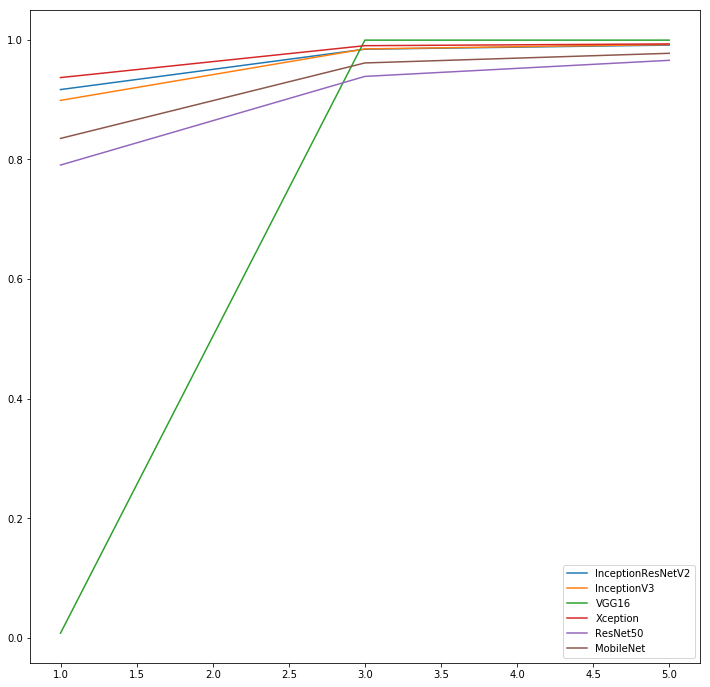

In [118]:
plt.figure(figsize=(12,12))
for model, history in results.items():
    plt.plot([1, 3, 5], [history["val_acc"][-1], history["val_top3"][-1], history["val_top5"][-1]] , label=model)
plt.legend()
plt.show()

# Fine Tuning Classifieur

In [4]:
data = np.load('preprocessed_train_Xception.npz')
X = data["X"]
y = data["y"]

label_binarizer = sklearn.preprocessing.LabelBinarizer()
y_bin = label_binarizer.fit_transform(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train, X_test, y_train_bin, y_test_bin = train_test_split(X, y_bin, test_size = 0.2, random_state=42)

## multinomial logistic regression (OVR-OVO Logisitc Regression)

In [8]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="log")
clf.fit(X_train, y_train)

print("training score : %.3f" % (clf.score(X_test, y_test)))

C:\Anaconda501\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


training score : 0.941


In [9]:
pred = clf.predict_proba(X_test[:10])

In [10]:
pred.shape

(10, 120)

## GradientBoostingClassifier

In [5]:
# Non gérable

# from sklearn.ensemble import GradientBoostingClassifier

# clf = GradientBoostingClassifier()
# clf.fit(X_train, y_train)

# # print the training scores
# print("training score : %.3f" % (clf.score(X_test, y_test), multi_class))

## SVC

In [ ]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(X_train, y_train)

# print the training scores
print("training score : %.3f" % (clf.score(X_test, y_test), multi_class))

## Random Forest

In [11]:
from sklearn.tree import ExtraTreeClassifier

clf = ExtraTreeClassifier(max_depth=20)
clf.fit(X_train, y_train)

# print the training scores
print("training score : %.3f" % (clf.score(X_test, y_test)))

training score : 0.611


Entre 20 et 50 de profondeur, la classification n'évolue plus

## NN

In [5]:
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

def swish(x):
    return x*K.sigmoid(x)

get_custom_objects().update({'custom_activation': swish})

In [16]:
batch_size = 64
optimiser = "Adadelta"
metrics = ["accuracy", top3, top5]
epoch_max = 100
split_cv = 0.1
verbose = 1

model = Sequential()

# 512 - D05 - 256 - 120 - Soft => 93,37% (loss = 0.546)
# 350 - D05 - 250 - D02 - 120 - Soft => 93,39% (loss = 0.43278)
# 250 - D02 - 120 - Soft => 94.01% (loss = 0.310)
# 200 - D03 - 120 - Soft => 94.59% (loss = 0.337)
# 200+elu - D03 - 120 - Soft => 95.55% (loss = 0.274)
# 250+elu - D02 - 120 - Soft => 95.33% (loss = 0.289)
# 200+swish - D02 - 120 - Soft => 95.64% (loss = 0.287)
# 200+relu - D02 - 120 - Soft => 95.79% (loss = 0.233)

model.add(Dense(200, input_dim=X.shape[1], activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(120, activation='softmax'))

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

model.compile(loss = "categorical_crossentropy", optimizer=optimiser, metrics=metrics)
model.fit(X_train, y_train_bin, 
          epochs=epoch_max, 
          batch_size=batch_size, 
          callbacks=[early_stop], 
          verbose=verbose, 
          shuffle=True, 
          validation_split=split_cv
         )
model.evaluate(X_test, y_test_bin)

Train on 14719 samples, validate on 1636 samples
Epoch 1/100
14719/14719 [==============================] - 2s 110us/step - loss: 1.6805 - acc: 0.7112 - top3: 0.8482 - top5: 0.8774 - val_loss: 0.4909 - val_acc: 0.8839 - val_top3: 0.9762 - val_top5: 0.9908
Epoch 2/100
14719/14719 [==============================] - 1s 93us/step - loss: 0.4335 - acc: 0.8837 - top3: 0.9803 - top5: 0.9902 - val_loss: 0.3895 - val_acc: 0.8955 - val_top3: 0.9774 - val_top5: 0.9902
Epoch 3/100
14719/14719 [==============================] - 1s 95us/step - loss: 0.3461 - acc: 0.8994 - top3: 0.9862 - top5: 0.9942 - val_loss: 0.3426 - val_acc: 0.9053 - val_top3: 0.9792 - val_top5: 0.9902
Epoch 4/100
14719/14719 [==============================] - 1s 95us/step - loss: 0.2992 - acc: 0.9087 - top3: 0.9893 - top5: 0.9960 - val_loss: 0.3246 - val_acc: 0.9010 - val_top3: 0.9817 - val_top5: 0.9921
Epoch 5/100
14719/14719 [==============================] - 1s 98us/step - loss: 0.2620 - acc: 0.9211 - top3: 0.9908 - top5: 0.

[0.16181233224629132,
 0.95597945718200839,
 0.99584250427977505,
 0.99804353142577651]

In [17]:
from keras.models import load_model

model.save('final_classifier.h5')

# Pour Kaggle

In [18]:
data = np.load('preprocessed_test_Xception.npz')
X = data["X"]
img_id = data["y"]

In [19]:
model = load_model('final_classifier.h5', custom_objects={'top3': top3, "top5" : top5})
pred = model.predict(X)

In [14]:
# pred = clf.predict_proba(X)

In [20]:
df = pd.DataFrame(pred)
df["id"] = img_id
df = df.set_index("id")
df.columns = label_binarizer.classes_

In [21]:
df = df.round(3)
df.to_csv("submission.csv")

In [22]:
df

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
id,,,,,,,,,,,,,,,,,,,,,
000621fb3cbb32d8935728e48679680e,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,...,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.0
00102ee9d8eb90812350685311fe5890,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,...,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.0
0012a730dfa437f5f3613fb75efcd4ce,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,...,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.0
001510bc8570bbeee98c8d80c8a95ec1,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,...,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.0
001a5f3114548acdefa3d4da05474c2e,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,...,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.0
00225dcd3e4d2410dd53239f95c0352f,0.0,0.001,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,...,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.0
002c2a3117c2193b4d26400ce431eebd,0.0,0.000,0.000,0.000,0.000,0.0,0.998,0.000,0.0,0.0,...,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.0
002c58d413a521ae8d1a5daeb35fc803,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,...,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.0
002f80396f1e3db687c5932d7978b196,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.0,...,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.0
